In [1]:
%cd ../..

D:\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-


In [2]:
import numpy as np
import pandas as pd
import time
import plotly.express as px
import plotly.graph_objects as go
import os
import plotly.io as pio
pio.templates.default = "plotly_white"

from pathlib import Path
from tqdm.autonotebook import tqdm
import warnings
import humanize

from darts.metrics import mase, mse, mae
from sklearn.preprocessing import StandardScaler

from src.utils.ts_utils import forecast_bias, darts_metrics_adapter
from src.utils.general import LogTime
from src.utils import plotting_utils
%load_ext autoreload
%autoreload 2
np.random.seed(42)
tqdm.pandas()

C:\Users\MANUJO~1\AppData\Local\Temp/ipykernel_24960/186276305.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
os.makedirs("imgs/chapter_7", exist_ok=True)
preprocessed = Path("data/london_smart_meters/preprocessed")
output = Path("data/london_smart_meters/output")

In [4]:
def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", title=""):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=900,
            height=500,
            title_text=title,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=12),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=12),
            )
        )
    return fig

In [5]:
#Readin the missing value imputed and train test split data
train_df = pd.read_parquet(preprocessed/"block_0-7_train_missing_imputed_feature_engg.parquet")
# Read in the Validation dataset as test_df so that we predict on it
test_df = pd.read_parquet(preprocessed/"block_0-7_val_missing_imputed_feature_engg.parquet")
# test_df = pd.read_parquet(preprocessed/"block_0-7_test_missing_imputed_feature_engg.parquet")

In [6]:
len(train_df.LCLid.unique())

399

# Feature Definition

In [7]:
date_col = "timestamp"
target_col = "energy_consumption"
index_cols = [date_col]
categorical_features= [
    'holidays',
    'precipType',
    'icon',
    'summary',
    'timestamp_Month',
    'timestamp_Quarter',
    'timestamp_WeekDay',
    'timestamp_Dayofweek',
    'timestamp_Dayofyear',
    'timestamp_Hour',
    'timestamp_Minute',

]
boolean_features = [
    'timestamp_Is_quarter_end',
    'timestamp_Is_quarter_start',
    'timestamp_Is_year_end',
    'timestamp_Is_year_start',
    'timestamp_Is_month_start',
]
continuous_features = [
 'visibility',
 'windBearing',
 'temperature',
 'dewPoint',
 'pressure',
 'apparentTemperature',
 'windSpeed',
 'humidity',
 'energy_consumption_lag_1',
 'energy_consumption_lag_2',
 'energy_consumption_lag_3',
 'energy_consumption_lag_4',
 'energy_consumption_lag_5',
 'energy_consumption_lag_49',
 'energy_consumption_lag_50',
 'energy_consumption_lag_51',
 'energy_consumption_lag_52',
 'energy_consumption_lag_53',
 'energy_consumption_rolling_3_mean',
 'energy_consumption_rolling_3_std',
 'energy_consumption_rolling_6_mean',
 'energy_consumption_rolling_6_std',
 'energy_consumption_rolling_12_mean',
 'energy_consumption_rolling_12_std',
 'energy_consumption_rolling_48_mean',
 'energy_consumption_rolling_48_std',
 'energy_consumption_48_seasonal_rolling_3_mean',
 'energy_consumption_48_seasonal_rolling_3_std',
 'energy_consumption_336_seasonal_rolling_3_mean',
 'energy_consumption_336_seasonal_rolling_3_std',
 'energy_consumption_ewma__span_2880',
 'energy_consumption_ewma__span_336',
 'energy_consumption_ewma__span_48',
 'timestamp_Elapsed',
 'timestamp_Month_sin_1',
 'timestamp_Month_sin_2',
 'timestamp_Month_sin_3',
 'timestamp_Month_sin_4',
 'timestamp_Month_sin_5',
 'timestamp_Month_cos_1',
 'timestamp_Month_cos_2',
 'timestamp_Month_cos_3',
 'timestamp_Month_cos_4',
 'timestamp_Month_cos_5',
 'timestamp_Hour_sin_1',
 'timestamp_Hour_sin_2',
 'timestamp_Hour_sin_3',
 'timestamp_Hour_sin_4',
 'timestamp_Hour_sin_5',
 'timestamp_Hour_cos_1',
 'timestamp_Hour_cos_2',
 'timestamp_Hour_cos_3',
 'timestamp_Hour_cos_4',
 'timestamp_Hour_cos_5',
 'timestamp_Minute_sin_1',
 'timestamp_Minute_sin_2',
 'timestamp_Minute_sin_3',
 'timestamp_Minute_sin_4',
 'timestamp_Minute_sin_5',
 'timestamp_Minute_cos_1',
 'timestamp_Minute_cos_2',
 'timestamp_Minute_cos_3',
 'timestamp_Minute_cos_4',
 'timestamp_Minute_cos_5']

exogenous_variables = [
    'holidays',
    'precipType',
    'icon',
    'summary',
    'visibility',
    'windBearing',
    'temperature',
    'dewPoint',
    'pressure',
    'apparentTemperature',
    'windSpeed',
    'humidity',
]

feature_list = categorical_features+continuous_features+boolean_features

assert target_col not in feature_list
assert date_col not in feature_list
assert len(set(exogenous_variables)-set(feature_list)) == 0
assert np.all([col in feature_list+[target_col, date_col] for col in index_cols])
dropped_columns = set(train_df.columns) - set(feature_list+[target_col, date_col])
print(f"Columns not being used: {dropped_columns}")

Columns not being used: {'series_length', 'stdorToU', 'LCLid', 'file', 'Acorn', 'Acorn_grouped', 'frequency'}


# Feature and Target Preparation

In [8]:
def get_X_y(df, categorical=False, exogenous=False):
    feature_list = continuous_features
    if categorical:
        feature_list += categorical_features
    if not exogenous:
        feature_list = list(set(feature_list)-set(exogenous_variables))
    return df.loc[:, feature_list+index_cols].set_index(index_cols), df.loc[:, [target_col]+index_cols].set_index(index_cols)

# Sample Household

In [9]:
train_features, train_target = get_X_y(train_df.loc[train_df.LCLid=="MAC000193",:], categorical=False, exogenous=False)
#Loading the Validation as test
test_features, test_target = get_X_y(test_df.loc[test_df.LCLid=="MAC000193",:], categorical=False, exogenous=False)

# Missing Value Handling

## Null check

In [10]:
nc = train_features.isnull().sum()
nc[nc>0]

energy_consumption_lag_53                           53
energy_consumption_lag_4                             4
energy_consumption_lag_5                             5
energy_consumption_rolling_48_std                   48
energy_consumption_rolling_3_std                     3
energy_consumption_rolling_48_mean                  48
energy_consumption_336_seasonal_rolling_3_mean    1008
energy_consumption_lag_49                           49
energy_consumption_rolling_6_std                     6
energy_consumption_lag_3                             3
energy_consumption_rolling_12_mean                  12
energy_consumption_48_seasonal_rolling_3_std       153
energy_consumption_48_seasonal_rolling_3_mean      144
energy_consumption_336_seasonal_rolling_3_std     1016
energy_consumption_rolling_12_std                   12
energy_consumption_rolling_3_mean                    3
energy_consumption_rolling_6_mean                    6
energy_consumption_lag_50                           50
energy_con

In [11]:
nc = test_features.isnull().sum()
nc[nc>0]

Series([], dtype: int64)

In [12]:
bfill_cols=['energy_consumption_lag_1',
 'energy_consumption_lag_2',
 'energy_consumption_lag_3',
 'energy_consumption_lag_4',
 'energy_consumption_lag_5',
 'energy_consumption_lag_49',
 'energy_consumption_lag_50',
 'energy_consumption_lag_51',
 'energy_consumption_lag_52',
 'energy_consumption_lag_53',
 'energy_consumption_rolling_3_mean',
 'energy_consumption_rolling_3_std',
 'energy_consumption_rolling_6_mean',
 'energy_consumption_rolling_6_std',
 'energy_consumption_rolling_12_mean',
 'energy_consumption_rolling_12_std',
 'energy_consumption_rolling_48_mean',
 'energy_consumption_rolling_48_std',
 'energy_consumption_48_seasonal_rolling_3_mean',
 'energy_consumption_48_seasonal_rolling_3_std',
 'energy_consumption_336_seasonal_rolling_3_mean',
 'energy_consumption_336_seasonal_rolling_3_std',
 'energy_consumption_ewma__span_2880',
 'energy_consumption_ewma__span_336',
 'energy_consumption_ewma__span_48']
zero_fill_cols = []

def impute_missing_values(df):
    df = df.copy()
    df[bfill_cols] = df[bfill_cols].fillna(method="bfill")
    df[zero_fill_cols] = df[zero_fill_cols].fillna(0)
    # Filling with mean as default fillna strategy
    return df.fillna(df.mean())

# Running ML models on a Sample household

In [13]:
pred_df = pd.concat([train_target, test_target])
metric_record = []

### Loading the single step backtesting baselines for validation

In [14]:
baseline_metrics_df = pd.read_pickle(output/"single_step_backtesting_baseline_metrics_val_df.pkl")
baseline_aggregate_metrics_df = pd.read_pickle(output/"single_step_backtesting_baseline_aggregate_metrics_val.pkl")
# baseline_metrics_test_df = pd.read_pickle(output/"single_step_backtesting_baseline_metrics_test_df.pkl")
# baseline_aggregate_metrics_test_df = pd.read_pickle(output/"single_step_backtesting_baseline_aggregate_metrics_test.pkl")

In [15]:
metric_record+=baseline_metrics_df.loc[baseline_metrics_df.LCLid=="MAC000193"].drop(columns="LCLid").to_dict(orient="records")

In [16]:
metric_record

[{'Algorithm': 'Naive',
  'MAE': 0.17533333599567413,
  'MSE': 0.10495548695325851,
  'MASE': 1.3664031028747559,
  'Forecast Bias': 0.026067355065606534},
 {'Algorithm': 'Seasonal Naive',
  'MAE': 0.2376619577407837,
  'MSE': 0.17094844579696655,
  'MASE': 1.85214102268219,
  'Forecast Bias': 4.796077683568001}]

In [17]:
def intersect_list(list1, list2):
    return list(set(list1).intersection(set(list2)))

def subtract_list(list1, list2):
    return list(set(list1)- set(list2))

def union_list(list1, list2):
    return list(set(list1).union(set(list2)))

In [18]:
def eval_model(model, train_features, train_target, test_features, test_target, name=None, fit_kwargs={}, normalize=True, fill_missing=True):
    if name is None:
        name = type(model).__name__
    if fill_missing:
        train_features = impute_missing_values(train_features)
        test_features = impute_missing_values(test_features)
    else:
        train_features = train_features.copy()
        test_features = test_features.copy()
    if normalize:
        scaler=StandardScaler()
        cont_cols =intersect_list(continuous_features, train_features.columns)
        train_features[cont_cols] = scaler.fit_transform(train_features[cont_cols])
        test_features[cont_cols] = scaler.transform(test_features[cont_cols])
    model.fit(train_features, train_target.values.ravel(), **fit_kwargs)
    if hasattr(model, "coef_") or hasattr(model, "feature_importances_"):
        feat_df = pd.DataFrame({"feature":train_features.columns,"importance":model.coef_.ravel() if hasattr(model, "coef_") else model.feature_importances_.ravel()})
        feat_df["_abs_imp"] = np.abs(feat_df.importance)
        feat_df = feat_df.sort_values("_abs_imp", ascending=False).drop(columns="_abs_imp")
    else:
        feat_df = pd.DataFrame()
    y_pred = model.predict(test_features)
    y_pred = pd.Series(y_pred.ravel(), index=test_target.index, name=name)
    return y_pred, {
        "Algorithm": name,
        "MAE": darts_metrics_adapter(mae, actual_series = test_target, pred_series = y_pred),
        "MSE": darts_metrics_adapter(mse, actual_series = test_target, pred_series = y_pred),
        "MASE": darts_metrics_adapter(mase, actual_series = test_target, pred_series = y_pred, insample=train_target),
        "Forecast Bias": darts_metrics_adapter(forecast_bias, actual_series = test_target, pred_series = y_pred)
    }, feat_df

In [19]:
from itertools import cycle
def plot_forecast(pred_df, forecast_columns, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns)==len(forecast_display_names)
    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = ["rgba("+",".join([str(c) for c in plotting_utils.hex_to_rgb(c)])+",<alpha>)" for c in px.colors.qualitative.Plotly]
    act_color = colors[0]
    colors = cycle(colors[1:])
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df[mask].energy_consumption,
                        mode='lines', line = dict(color=act_color.replace("<alpha>", "0.9")),
                        name='Actual Consumption'))
    for col, display_col in zip(forecast_columns,forecast_display_names):
        fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df.loc[mask, col],
                            mode='lines', line = dict(dash='dot', color=next(colors).replace("<alpha>", "1")),
                            name=display_col))
    return fig

## Linear Models

In [20]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV

### Linear Regression

In [21]:
name = "Linear Regression"
model = LinearRegression()
with LogTime() as timer:
    y_pred, metrics, feat_df = eval_model(model, train_features, train_target, test_features, test_target, name=name, normalize=True, fill_missing=True)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
pred_df = pred_df.join(y_pred)

Time Elapsed: 1 second


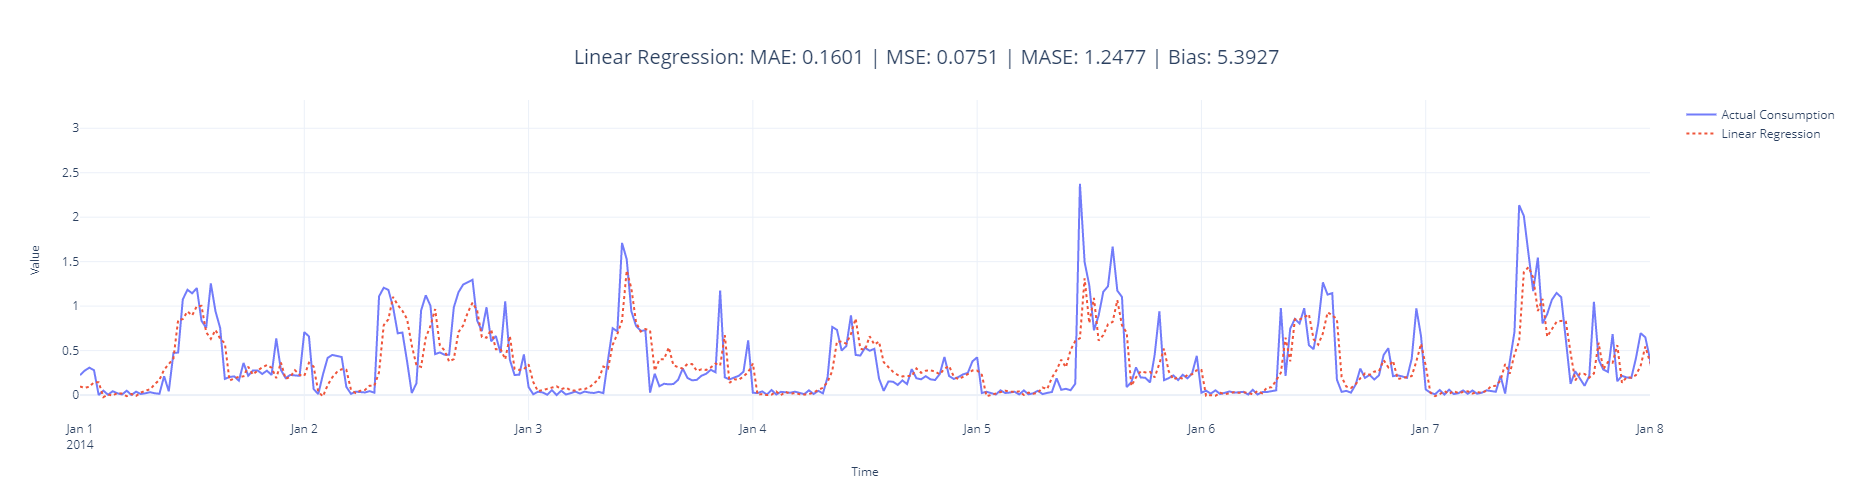

In [22]:
fig = plot_forecast(pred_df, forecast_columns=[name], forecast_display_names=[name])
fig = format_plot(fig, title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_7/lin_reg.png")
fig.show()

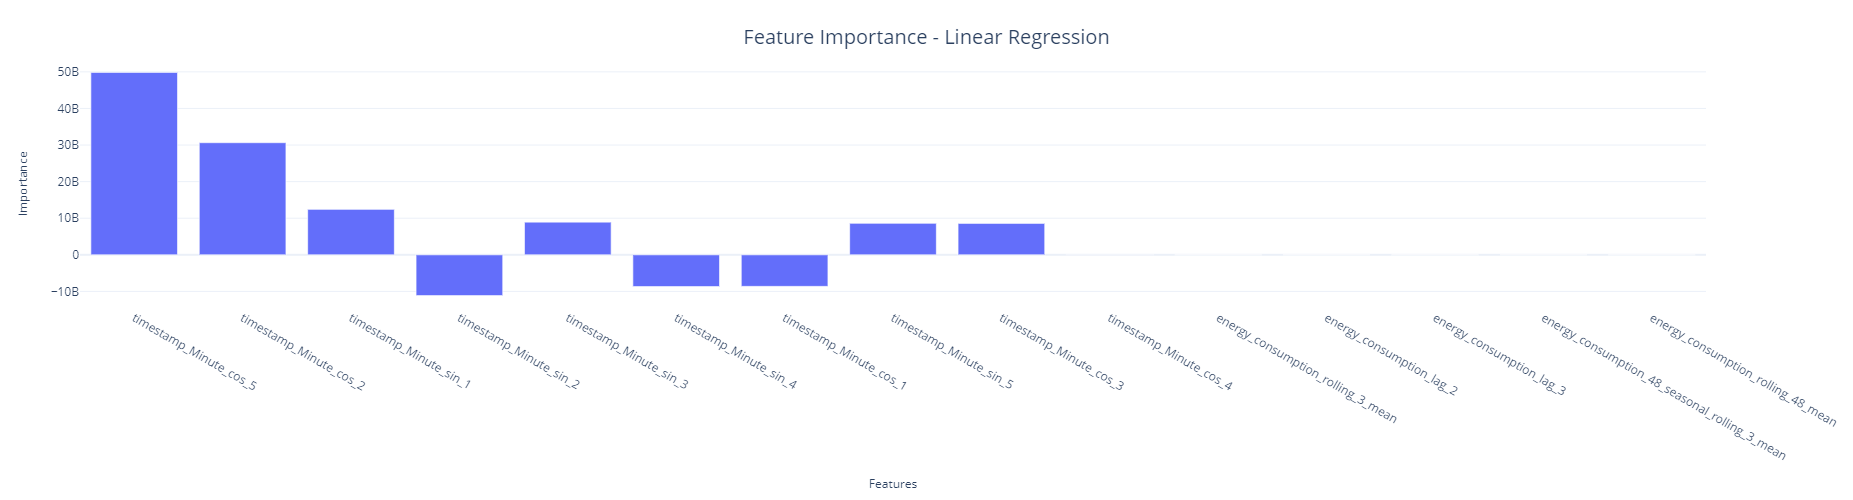

In [23]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Feature Importance - {name}")
fig.write_image("imgs/chapter_7/lin_reg_fimp.png")
fig.show()

### Ridge Regression (L2)

In [24]:
name = "Ridge Regression"
model = RidgeCV()
with LogTime() as timer:
    y_pred, metrics, feat_df = eval_model(model, train_features, train_target, test_features, test_target, name=name, normalize=True, fill_missing=True)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


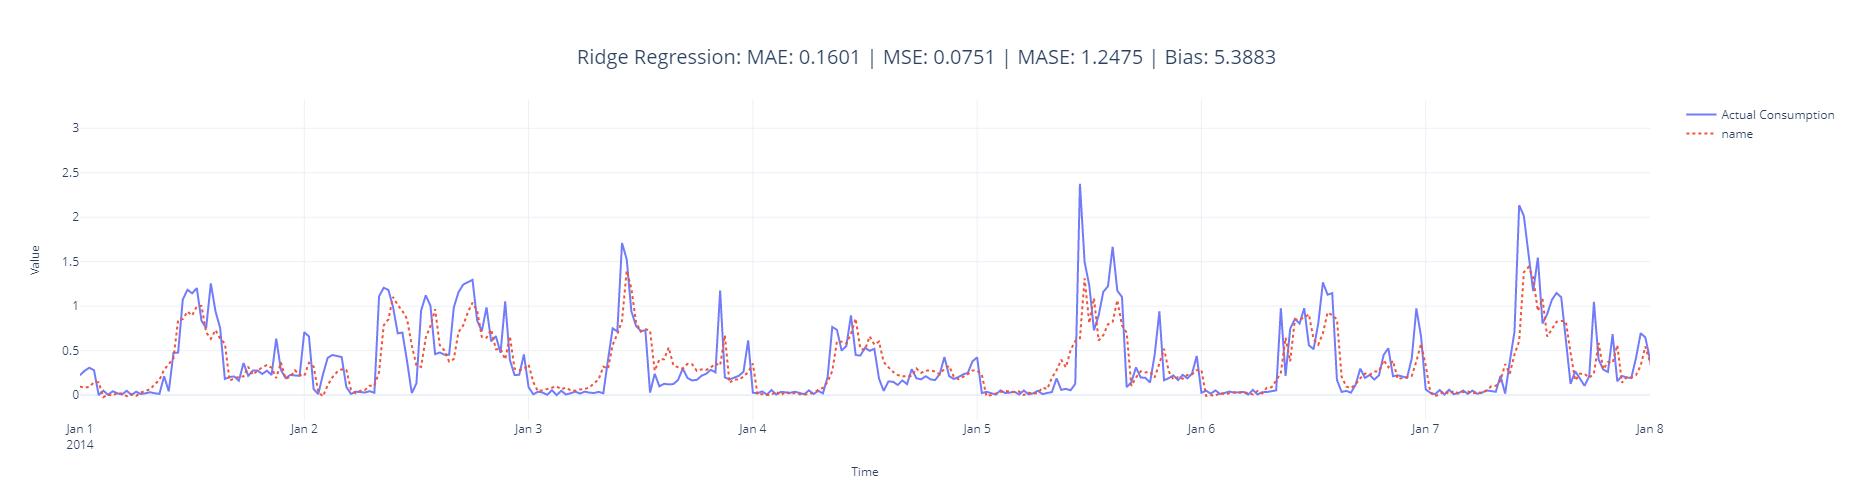

In [25]:
fig = plot_forecast(pred_df, forecast_columns=[name], forecast_display_names=['name'])
fig = format_plot(fig, title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_7/ridge_reg.png")
fig.show()

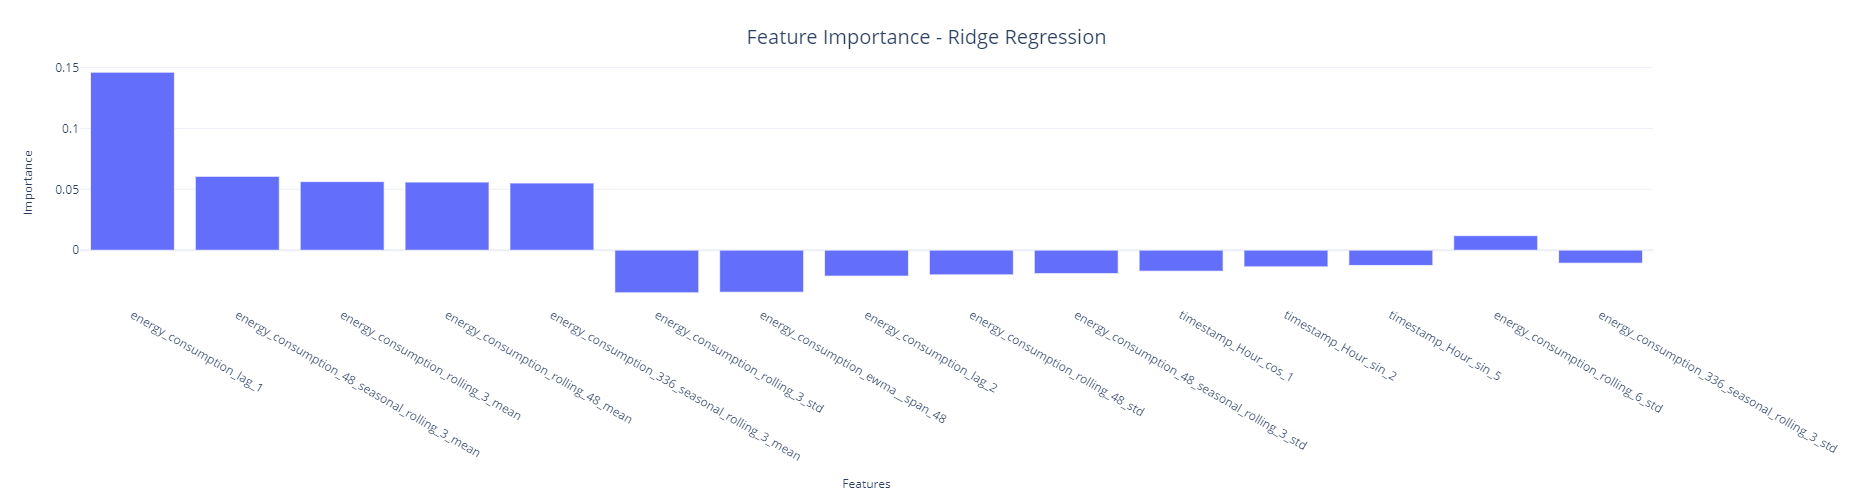

In [26]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Feature Importance - {name}")
fig.write_image("imgs/chapter_7/ridge_reg_fimp.png")
fig.show()

### Lasso Regression (L1)

In [27]:
name = "Lasso Regression"
model = LassoCV()
with LogTime() as timer:
    y_pred, metrics, feat_df = eval_model(model, train_features, train_target, test_features, test_target, name=name, normalize=True, fill_missing=True)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
pred_df = pred_df.join(y_pred)

Time Elapsed: 1 second


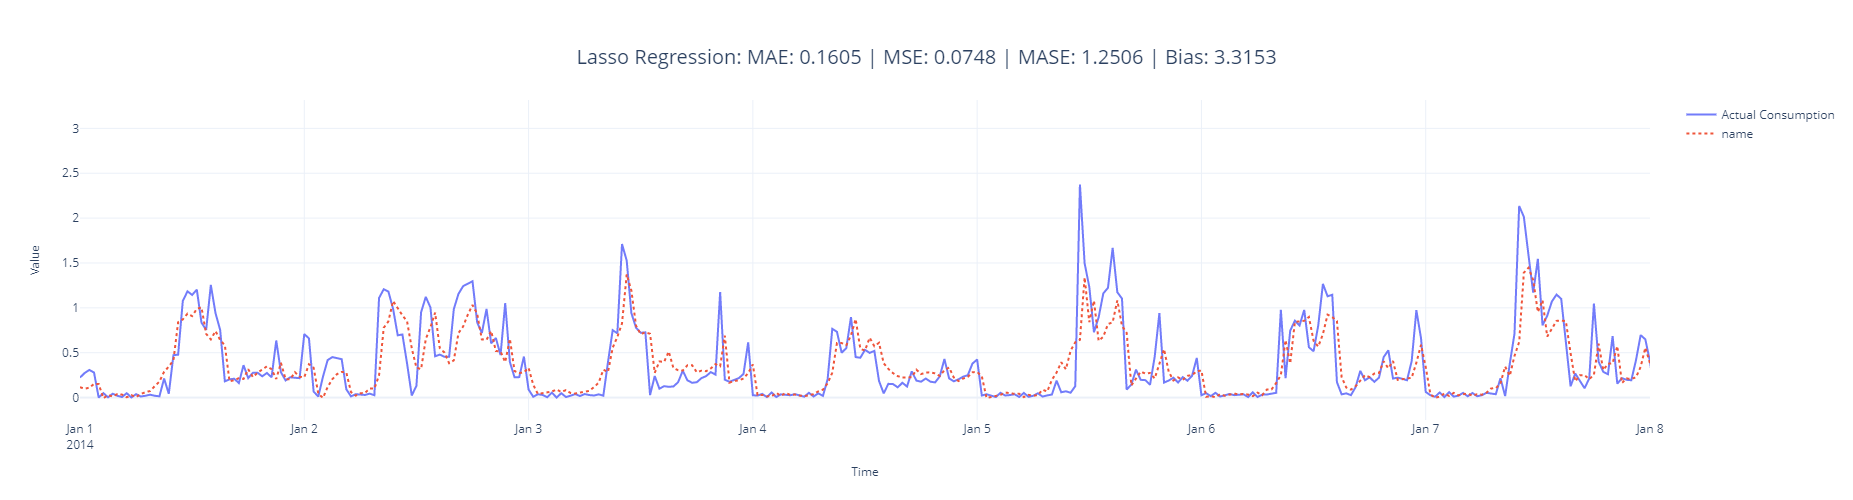

In [28]:
fig = plot_forecast(pred_df, forecast_columns=[name], forecast_display_names=['name'])
fig = format_plot(fig, title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_7/lasso_reg.png")
fig.show()

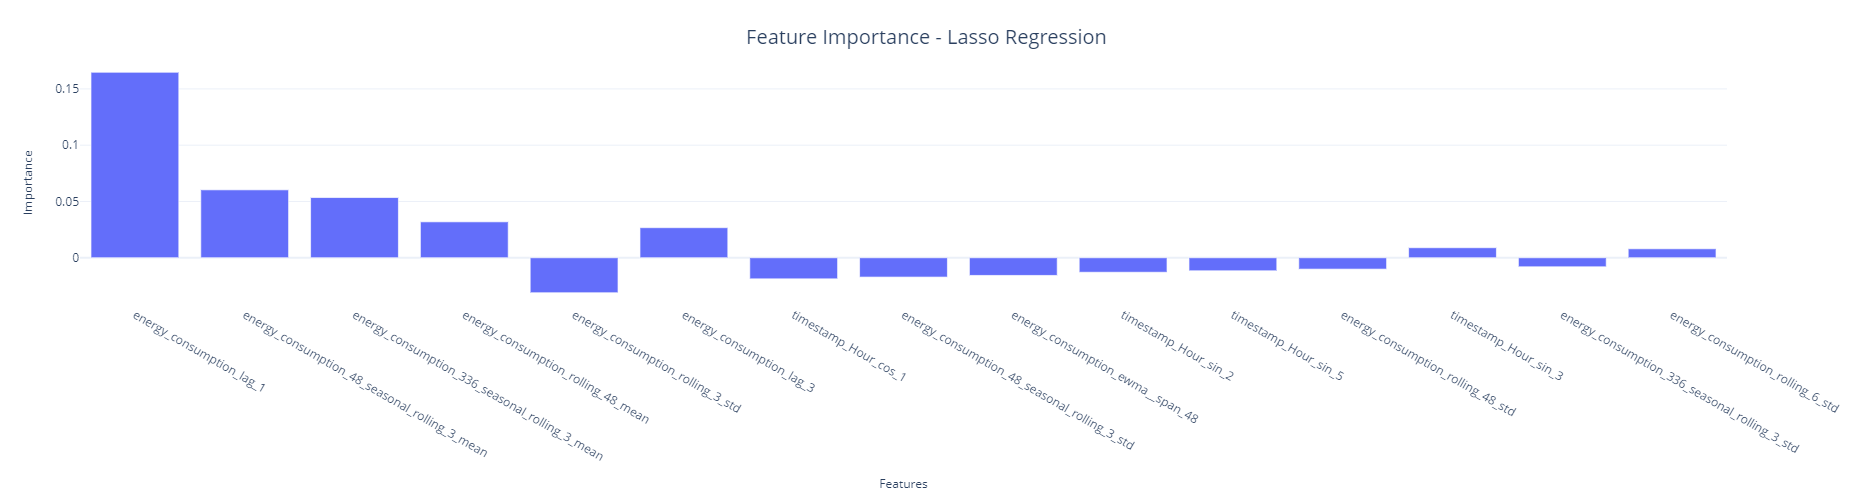

In [29]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Feature Importance - {name}")
fig.write_image("imgs/chapter_7/lasso_reg_fimp.png")
fig.show()

## Decision Tree

In [30]:
from sklearn.tree import DecisionTreeRegressor

In [31]:
name = "Decision Tree"
model = DecisionTreeRegressor(max_depth = 4, random_state=42)
with LogTime() as timer:
    y_pred, metrics, feat_df = eval_model(model, train_features, train_target, test_features, test_target, name=name, normalize=True, fill_missing=True)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


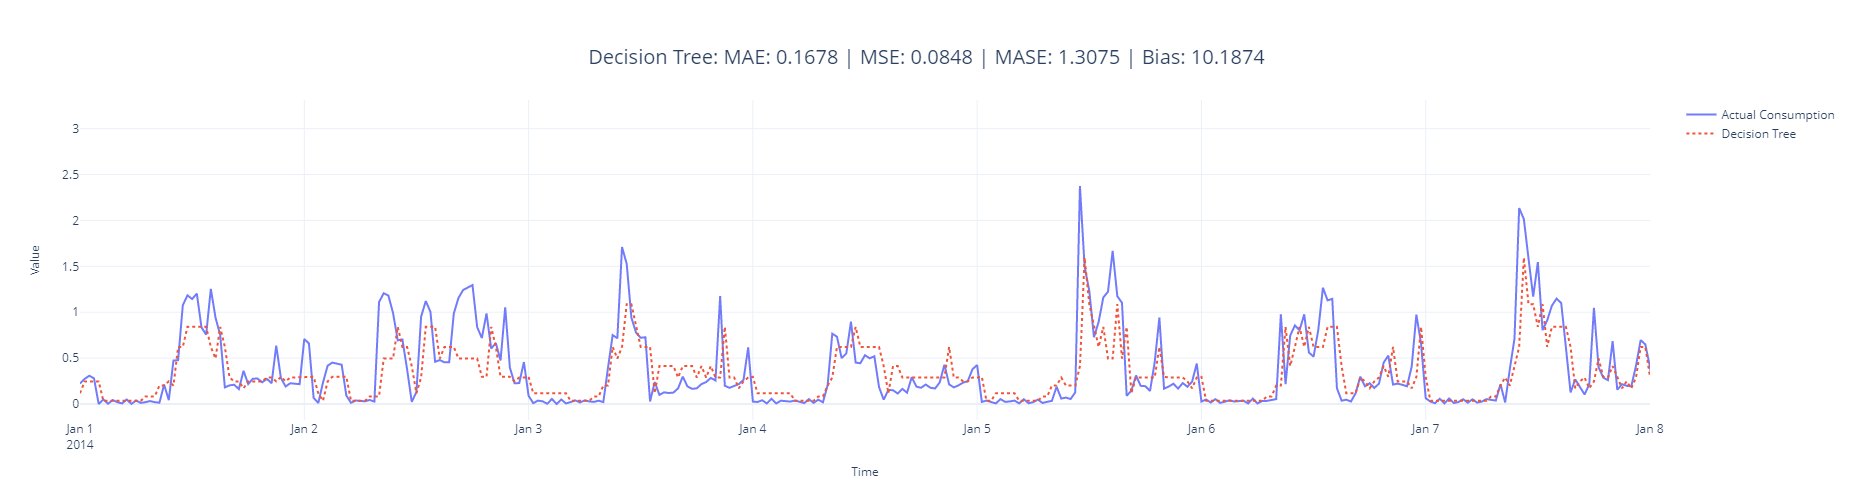

In [32]:
fig = plot_forecast(pred_df, forecast_columns=[name], forecast_display_names=[name])
fig = format_plot(fig, title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_7/dtree.png")
fig.show()

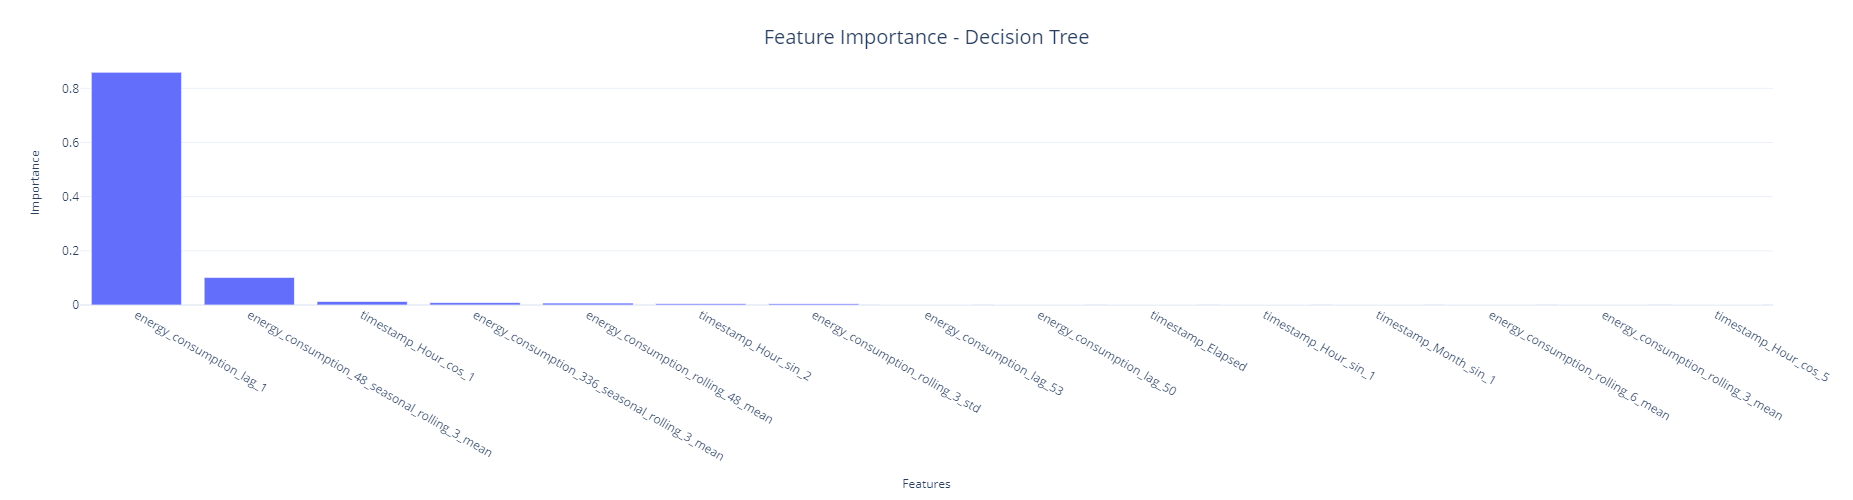

In [33]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Feature Importance - {name}")
fig.write_image("imgs/chapter_7/dtree_fimp.png")
fig.show()

## Bagging and Boosting Trees

### Random Forest

In [34]:
from sklearn.ensemble import RandomForestRegressor

In [35]:
name = "Random Forest"
model = RandomForestRegressor(random_state=42, max_depth=4)
with LogTime() as timer:
    y_pred, metrics, feat_df = eval_model(model, train_features, train_target, test_features, test_target, name=name, normalize=False, fill_missing=True)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
pred_df = pred_df.join(y_pred)

Time Elapsed: 19 seconds


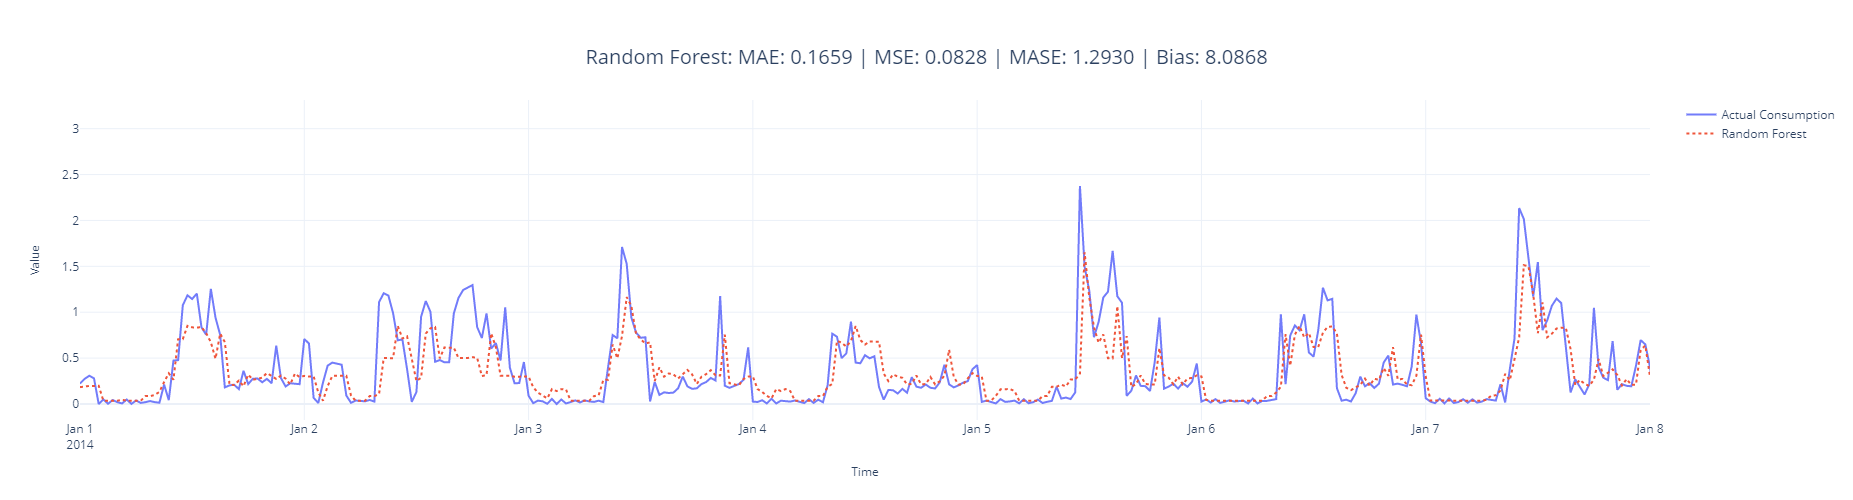

In [36]:
fig = plot_forecast(pred_df, forecast_columns=[name], forecast_display_names=[name])
fig = format_plot(fig, title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_7/rf.png")
fig.show()

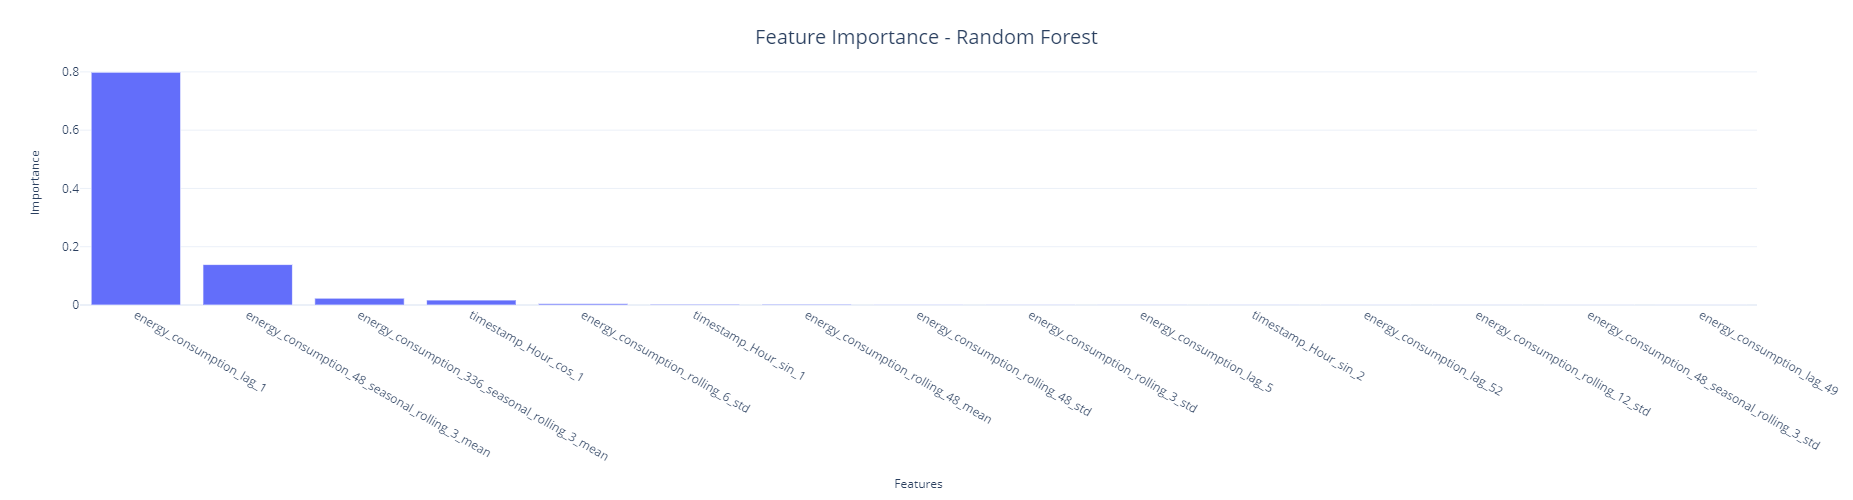

In [37]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Feature Importance - {name}")
fig.write_image("imgs/chapter_7/rf_fimp.png")
fig.show()

### XGBoost Random Forest

In [38]:
from xgboost import XGBRFRegressor

In [39]:
name = "XGB Random Forest"
model = XGBRFRegressor(random_state=42, max_depth=4)
with LogTime() as timer:
    y_pred, metrics, feat_df = eval_model(model, train_features, train_target, test_features, test_target, name=name, normalize=False, fill_missing=True)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
pred_df = pred_df.join(y_pred)

Time Elapsed: 2 seconds


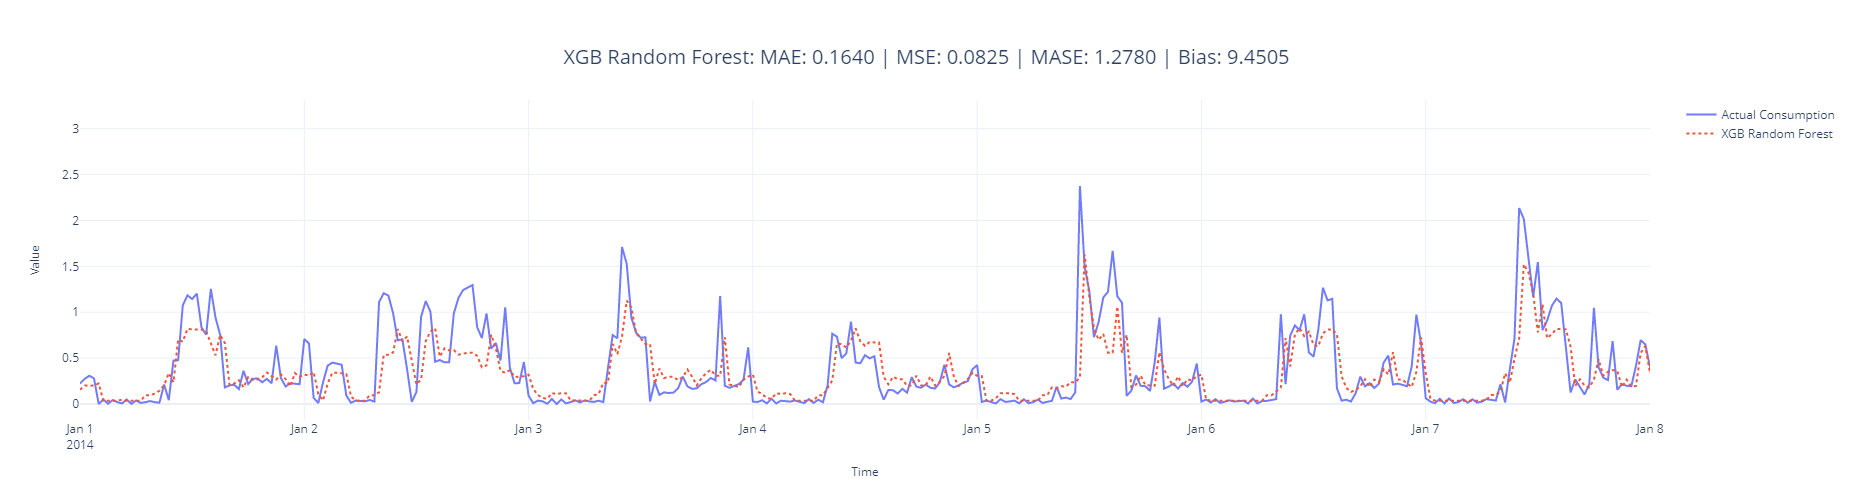

In [40]:
fig = plot_forecast(pred_df, forecast_columns=[name], forecast_display_names=[name])
fig = format_plot(fig, title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_7/xgbrf.png")
fig.show()

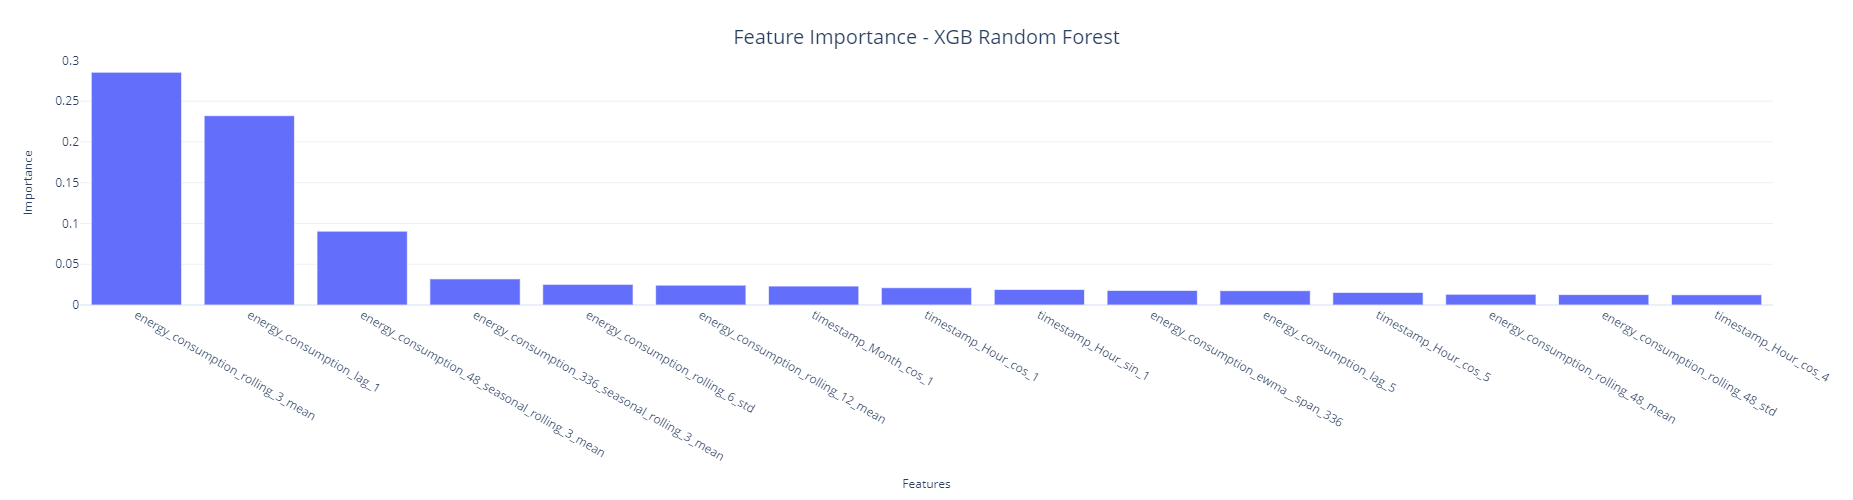

In [41]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Feature Importance - {name}")
fig.write_image("imgs/chapter_7/xgbrf_fimp.png")
fig.show()

### LightGBM

In [42]:
from lightgbm import LGBMRegressor

In [43]:
name = "LightGBM"
model = LGBMRegressor(random_state=42)
with LogTime() as timer:
    y_pred, metrics, feat_df = eval_model(model, train_features, train_target, test_features, test_target, name=name, normalize=False, fill_missing=True)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


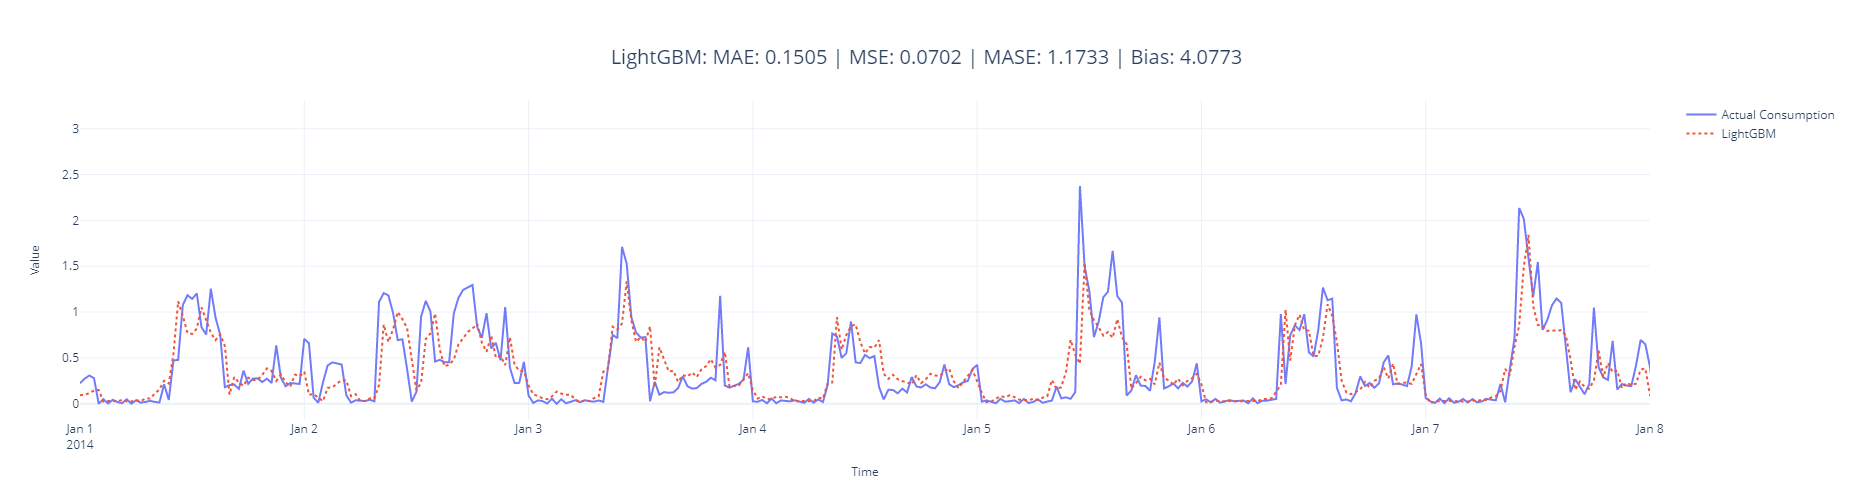

In [44]:
fig = plot_forecast(pred_df, forecast_columns=[name], forecast_display_names=[name])
fig = format_plot(fig, title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_7/lgbm.png")
fig.show()

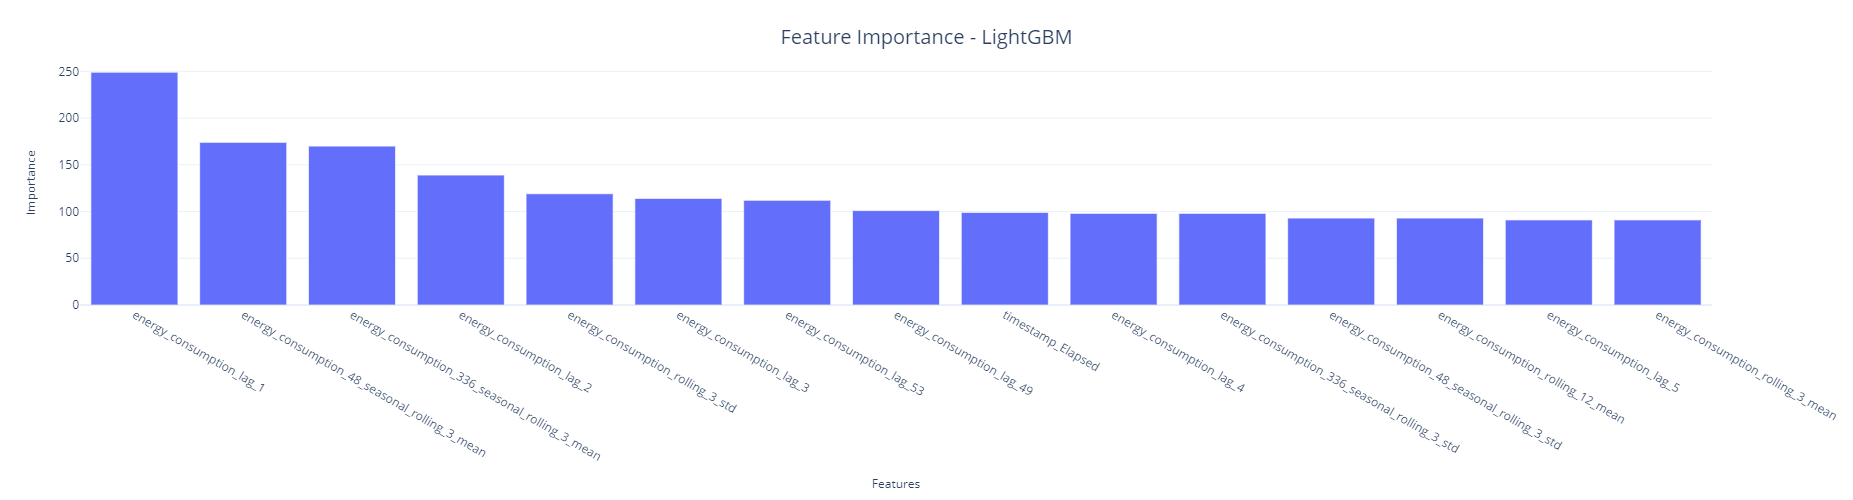

In [45]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Feature Importance - {name}")
fig.write_image("imgs/chapter_7/lgbm_fimp.png")
fig.show()

## Summary

In [46]:
def highlight_abs_min(s, props=''):
    return np.where(s == np.nanmin(np.abs(s.values)), props, '')

formatted = pd.DataFrame(metric_record).style.format({"MAE": "{:.3f}", 
                          "MSE": "{:.3f}", 
                          "MASE": "{:.3f}", 
                          "Forecast Bias": "{:.2f}%"})
formatted.highlight_min(color='lightgreen', subset=["MAE","MSE","MASE"]).apply(highlight_abs_min, props='color:black;background-color:lightgreen', axis=0, subset=['Forecast Bias'])

# Running ML Forecast for all consumers

Running Lasso Regression, XGB Random Forest, and LightGBM

In [47]:
from sklearn.base import clone
from collections import namedtuple

In [48]:
lcl_ids = sorted(train_df.LCLid.unique())

model_tuple = namedtuple("Model", ["name", "model", "normalize", "fill_missing", "encode_categorical"])
models_to_run = [
    model_tuple("Lasso", LassoCV(random_state=42), True, True, True),
    model_tuple("XGBRandomForest", XGBRFRegressor(random_state=42), False, True, True),
    model_tuple("LightGBM", LGBMRegressor(random_state=42), False, True, False),
]

In [49]:
all_preds = []
all_metrics = []
#We can parallelize this loop to run this faster
for lcl_id in tqdm(lcl_ids):
    for model in models_to_run:
        _model = clone(model.model)
        X_train, y_train = get_X_y(train_df.loc[train_df.LCLid==lcl_id,:], categorical=False, exogenous=False)
        X_test, y_test = get_X_y(test_df.loc[test_df.LCLid==lcl_id,:], categorical=False, exogenous=False)
        y_pred, metrics, feat_df = eval_model(_model, X_train, y_train, X_test, y_test, name=model.name, normalize=model.normalize, fill_missing=model.fill_missing)
        y_pred.name = "predictions"
        y_pred = y_pred.to_frame()
        y_pred['LCLid'] = lcl_id
        y_pred['Algorithm'] = model.name
        metrics["LCLid"] = lcl_id
        metrics["Algorithm"] = model.name
        y_pred['energy_consumption'] = y_test.values
        all_preds.append(y_pred)
        all_metrics.append(metrics)

  0%|          | 0/399 [00:00<?, ?it/s]

D:\miniconda3\envs\modern_ts_v5\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7927284907012222, tolerance: 0.05337182653744511

D:\miniconda3\envs\modern_ts_v5\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.83203499183537, tolerance: 1.3117940211102046

D:\miniconda3\envs\modern_ts_v5\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.414329075509386, tolerance: 0.3171271224822883

D:\miniconda3\envs\modern_ts_v5\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duali

In [50]:
pred_df = pd.concat(all_preds)
pred_df.head()

predictions      LCLid Algorithm  energy_consumption
timestamp                                                                
2014-01-01 00:00:00     0.455831  MAC000002     Lasso               0.496
2014-01-01 00:30:00     0.471103  MAC000002     Lasso               0.427
2014-01-01 01:00:00     0.443623  MAC000002     Lasso               0.469
2014-01-01 01:30:00     0.438383  MAC000002     Lasso               0.362
2014-01-01 02:00:00     0.312954  MAC000002     Lasso               0.452

In [51]:
metrics_df = pd.DataFrame(all_metrics)
metrics_df.head()

Algorithm       MAE       MSE      MASE  Forecast Bias      LCLid
0            Lasso  0.106270  0.033688  0.986824      -1.153783  MAC000002
1  XGBRandomForest  0.103646  0.035069  0.962459      -0.257188  MAC000002
2         LightGBM  0.092368  0.030081  0.857732      -0.058402  MAC000002
3            Lasso  0.054963  0.010999  0.976264       1.050371  MAC000005
4  XGBRandomForest  0.051102  0.009437  0.907680       0.041228  MAC000005

# Evaluation of ML Forecast

In [52]:
from src.utils import ts_utils

In [53]:
baseline_aggregate_metrics_df

MAE       MSE  meanMASE  Forecast Bias
Naive           0.111043  0.054808  1.009591       0.005201
Seasonal Naive  0.175735  0.123515  1.571673       1.660885

In [54]:
metrics = baseline_aggregate_metrics_df.reset_index().rename(columns={"index":"Algorithm"}).to_dict(orient="records")

In [55]:

for model in models_to_run:
    pred_mask = pred_df.Algorithm==model.name
    metric_mask = metrics_df.Algorithm==model.name
    metrics.append({
    "Algorithm": model.name,
    "MAE": ts_utils.mae(pred_df.loc[pred_mask,"energy_consumption"], pred_df.loc[pred_mask,"predictions"]),
    "MSE": ts_utils.mse(pred_df.loc[pred_mask,"energy_consumption"], pred_df.loc[pred_mask,"predictions"]),
    "meanMASE": metrics_df.loc[metric_mask, "MASE"].mean(),
    "Forecast Bias": ts_utils.forecast_bias_aggregate(pred_df.loc[pred_mask,"energy_consumption"], pred_df.loc[pred_mask,"predictions"])
})

In [56]:
agg_metrics_df = pd.DataFrame(metrics)
agg_metrics_df.style.format({"MAE": "{:.3f}", 
                          "MSE": "{:.3f}", 
                          "meanMASE": "{:.3f}", 
                          "Forecast Bias": "{:.2f}%"}).highlight_min(color='lightgreen', subset=["MAE","MSE","meanMASE"]).apply(highlight_abs_min, props='color:black;background-color:lightgreen', axis=0, subset=['Forecast Bias'])

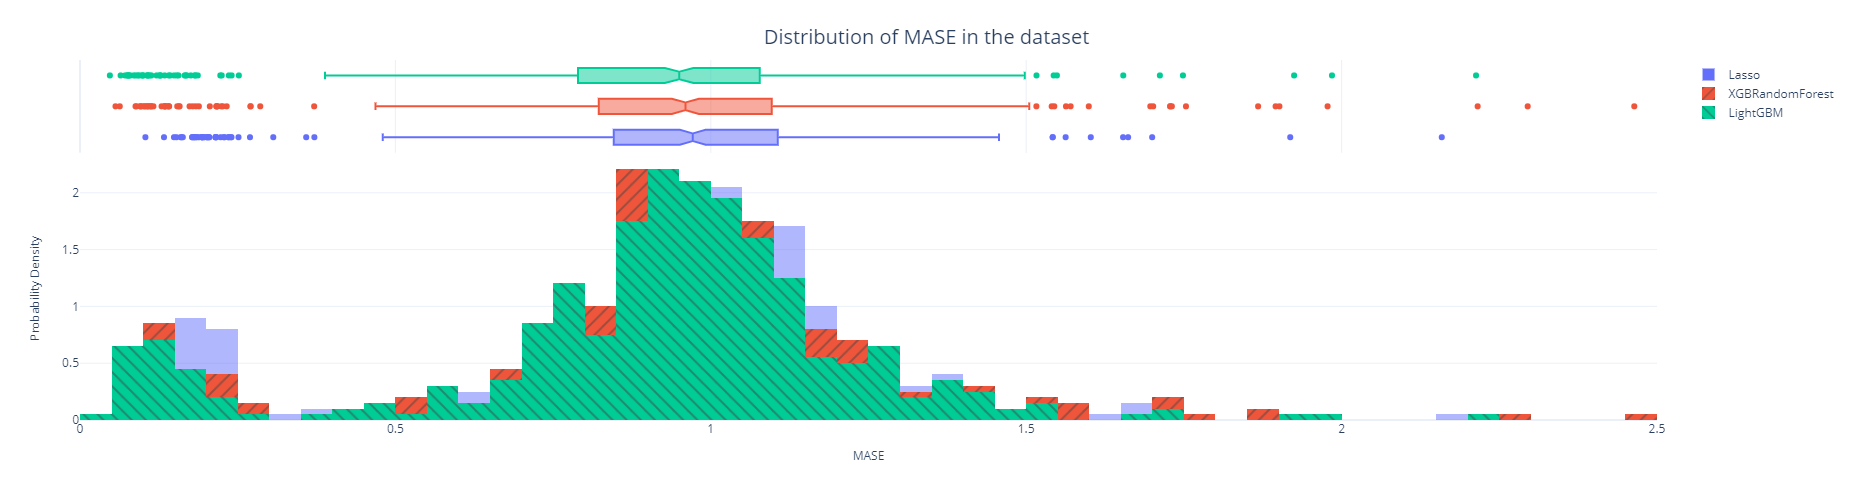

In [57]:
fig = px.histogram(metrics_df, 
                   x="MASE", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=500, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MASE", ylabel="Probability Density", title="Distribution of MASE in the dataset")
fig.update_layout(xaxis_range=[0,2.5])
fig.write_image("imgs/chapter_7/mase_dist.png")
fig.show()

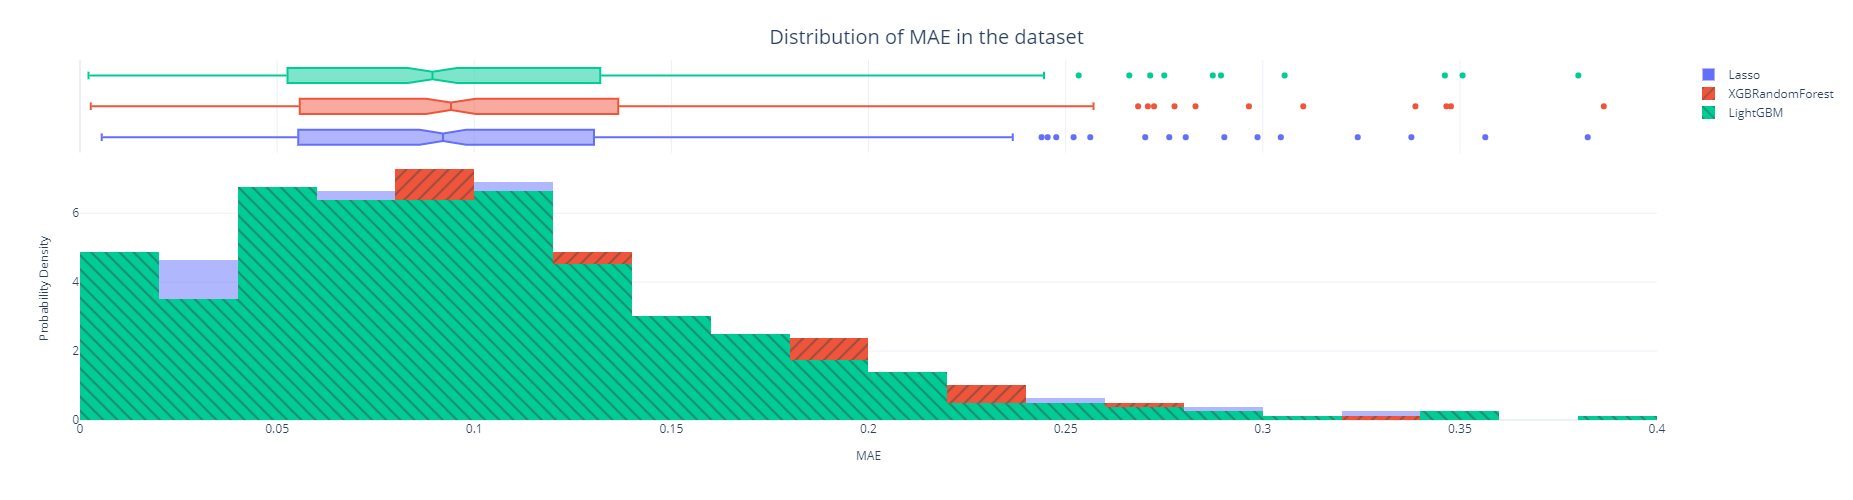

In [58]:
fig = px.histogram(metrics_df, 
                   x="MAE", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=100, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MAE", ylabel="Probability Density", title="Distribution of MAE in the dataset")
fig.write_image("imgs/chapter_7/mae_dist.png")
fig.update_layout(xaxis_range=[0,0.4])
fig.show()

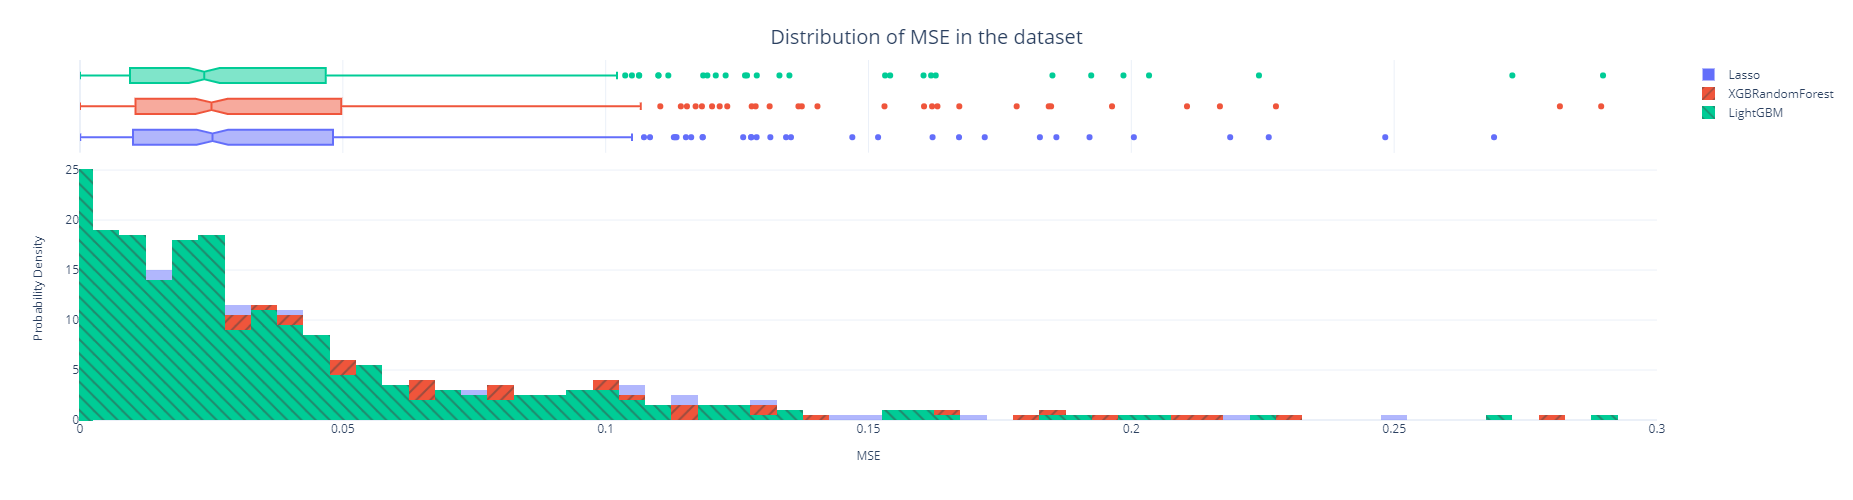

In [59]:
fig = px.histogram(metrics_df, 
                   x="MSE", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=500, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MSE", ylabel="Probability Density", title="Distribution of MSE in the dataset")
fig.update_layout(xaxis_range=[0,0.3])
fig.write_image("imgs/chapter_7/mse_dist.png")
fig.show()

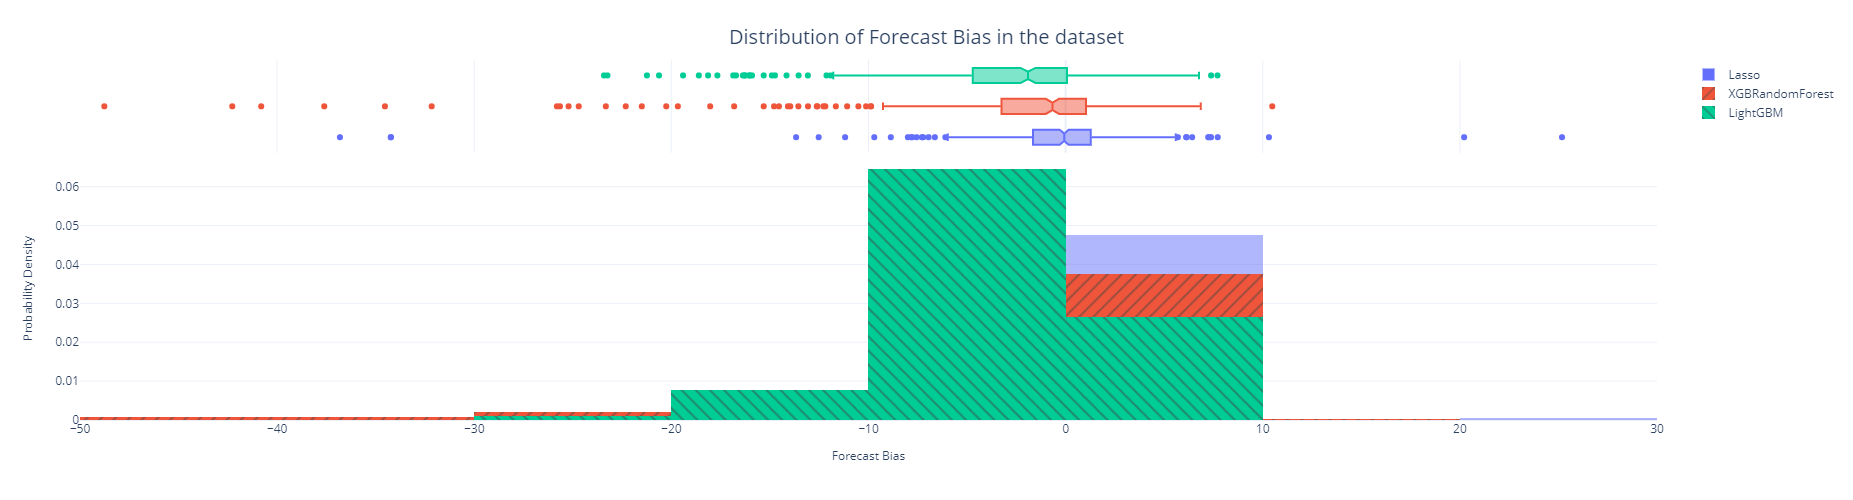

In [60]:
fig = px.histogram(metrics_df, 
                   x="Forecast Bias", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=250,
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="Forecast Bias", ylabel="Probability Density", title="Distribution of Forecast Bias in the dataset")
fig.update_layout(xaxis_range=[-50,30])
fig.write_image("imgs/chapter_7/bias_dist.png")
fig.show()

# Saving the Baseline Forecasts and Metrics

In [61]:
os.makedirs("data/london_smart_meters/output", exist_ok=True)
output = Path("data/london_smart_meters/output")

In [62]:
pred_df.to_pickle(output/"ml_single_step_prediction_val_df.pkl")
metrics_df.to_pickle(output/"ml_single_step_metrics_val_df.pkl")
agg_metrics_df.to_pickle(output/"ml_single_step_aggregate_metrics_val.pkl")

# Bonus: Using Exogenous Variables

We can run LightGBM, which was our best performing algorithm with exogenous variables

In [63]:
lcl_ids = sorted(train_df.LCLid.unique())

model_tuple = namedtuple("Model", ["name", "model", "normalize", "fill_missing", "encode_categorical"])
models_to_run = [
    model_tuple("LightGBM", LGBMRegressor(random_state=42), False, True, False),
]

In [64]:
all_preds = []
all_metrics = []
#We can parallelize this loop to run this faster
for lcl_id in tqdm(lcl_ids):
    for model in models_to_run:
        _model = clone(model.model)
        X_train, y_train = get_X_y(train_df.loc[train_df.LCLid==lcl_id,:], categorical=False, exogenous=True)
        X_test, y_test = get_X_y(test_df.loc[test_df.LCLid==lcl_id,:], categorical=False, exogenous=True)
        y_pred, metrics, feat_df = eval_model(_model, X_train, y_train, X_test, y_test, name=model.name, normalize=model.normalize, fill_missing=model.fill_missing)
        y_pred.name = "predictions"
        y_pred = y_pred.to_frame()
        y_pred['LCLid'] = lcl_id
        y_pred['Algorithm'] = model.name+"_w_exog"
        metrics["LCLid"] = lcl_id
        metrics["Algorithm"] = model.name+"_w_exog"
        y_pred['energy_consumption'] = y_test.values
        all_preds.append(y_pred)
        all_metrics.append(metrics)

  0%|          | 0/399 [00:00<?, ?it/s]

In [65]:
pred_w_ex_df = pd.concat(all_preds)
pred_w_ex_df.head()

predictions      LCLid        Algorithm  \
timestamp                                                      
2014-01-01 00:00:00     0.396893  MAC000002  LightGBM_w_exog   
2014-01-01 00:30:00     0.415140  MAC000002  LightGBM_w_exog   
2014-01-01 01:00:00     0.374139  MAC000002  LightGBM_w_exog   
2014-01-01 01:30:00     0.362703  MAC000002  LightGBM_w_exog   
2014-01-01 02:00:00     0.315127  MAC000002  LightGBM_w_exog   

                     energy_consumption  
timestamp                                
2014-01-01 00:00:00               0.496  
2014-01-01 00:30:00               0.427  
2014-01-01 01:00:00               0.469  
2014-01-01 01:30:00               0.362  
2014-01-01 02:00:00               0.452

In [66]:
metrics_w_ex_df = pd.DataFrame(all_metrics)
metrics_w_ex_df.head()

Algorithm       MAE       MSE      MASE  Forecast Bias      LCLid
0  LightGBM_w_exog  0.094734  0.030241  0.879707      -0.121647  MAC000002
1  LightGBM_w_exog  0.050001  0.008449  0.888121      -3.931649  MAC000005
2  LightGBM_w_exog  0.057397  0.011409  0.863705       0.532976  MAC000017
3  LightGBM_w_exog  0.104465  0.035333  0.957374      -3.300778  MAC000030
4  LightGBM_w_exog  0.242477  0.116659  1.279804      -8.239180  MAC000040

## Evaluation of ML Forecast with Exogenous

In [67]:
from src.utils import ts_utils

In [68]:
metrics = baseline_aggregate_metrics_df.reset_index().rename(columns={"index":"Algorithm"}).to_dict(orient="records")

In [69]:
metrics.append(agg_metrics_df.iloc[4].to_dict())

In [70]:

for model in models_to_run:
    pred_mask = pred_w_ex_df.Algorithm==model.name+"_w_exog"
    metric_mask = metrics_w_ex_df.Algorithm==model.name+"_w_exog"
    metrics.append({
    "Algorithm": model.name+"_w_exog",
    "MAE": ts_utils.mae(pred_w_ex_df.loc[pred_mask,"energy_consumption"], pred_w_ex_df.loc[pred_mask,"predictions"]),
    "MSE": ts_utils.mse(pred_w_ex_df.loc[pred_mask,"energy_consumption"], pred_w_ex_df.loc[pred_mask,"predictions"]),
    "meanMASE": metrics_w_ex_df.loc[metric_mask, "MASE"].mean(),
    "Forecast Bias": ts_utils.forecast_bias_aggregate(pred_w_ex_df.loc[pred_mask,"energy_consumption"], pred_w_ex_df.loc[pred_mask,"predictions"])
})

In [71]:
agg_metrics_w_ex_df = pd.DataFrame(metrics)
agg_metrics_w_ex_df.style.format({"MAE": "{:.3f}", 
                          "MSE": "{:.3f}", 
                          "meanMASE": "{:.3f}", 
                          "Forecast Bias": "{:.2f}%"}).highlight_min(color='lightgreen', subset=["MAE","MSE","meanMASE"]).apply(highlight_abs_min, props='color:black;background-color:lightgreen', axis=0, subset=['Forecast Bias'])